# Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
import seaborn as sns
import pyarrow.feather as feather

import sklearn.preprocessing as skl_preprocessing
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import tensorflow.keras.layers.experimental.preprocessing as tf_preprocessing
from tensorflow.python.keras.layers import Dense, Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.callbacks import EarlyStopping

from datetime import datetime
from keras.callbacks import TensorBoard

In [2]:
# Load the TensorBoard notebook extension.
# %load_ext tensorboard

# Clear any logs from previous runs
# !rm -rf ./logs/

In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7108337071219667347
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 22729785344
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 6587323751467422031
 physical_device_desc: "device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [49]:
input_root_path = "P:\SALMALIS Lab\Work Zone Dataset"
output_root_path = "../"

# Load Dataset

In [10]:
# df = feather.read_feather(os.path.join(input_root_path, 'TravelTime_Valid_Recom_Weather_Traffic.ftr'))
# df = pd.read_csv(os.path.join(input_root_path, 'TravelTime_Valid_Recom_Weather_Traffic.csv'))
# df

In [11]:
# Get No Cell Coverage Area Assets
# assets_no_cell = pd.read_csv(os.path.join(input_root_path, 'NoCellAssets.csv'))['Asset Number'].tolist()

# df[df['AssetNumber'].isin(assets_no_cell)].to_csv(os.path.join(input_root_path, 'TravelTime_NoCellCoverage.csv'))
# feather.write_feather(df[df['AssetNumber'].isin(assets_no_cell)], os.path.join(input_root_path, 'TravelTime_NoCellCoverage.ftr'))

# Remove no cell coverage records from data frame
# df = df[~df['AssetNumber'].isin(assets_no_cell)]
# df

# df.to_csv(os.path.join(input_root_path, 'TravelTime_HaveCellCoverage.csv'))
# feather.write_feather(df, os.path.join(input_root_path, 'TravelTime_HaveCellCoverage.ftr'))

In [9]:
df = feather.read_feather(os.path.join(input_root_path, 'TravelTime_HaveCellCoverage.ftr'))
df

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,Weather:Lat,Weather:Temp,Weather:Precip,Weather:WindSpd,Traffic:SiteNo,Traffic:IsTemporary,Traffic:AADT,Traffic:BaseYear,Traffic:CalculatedAADT,MaxSpeed
0,49831911074,Spread 3B,2022-05-03 17:59:55,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
1,49831911074,Spread 3B,2022-05-03 17:57:32,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
2,49831911074,Spread 3B,2022-05-03 17:55:23,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
3,49831911074,Spread 3B,2022-05-03 17:53:29,2.20,2.13,0.07,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
4,49831911074,Spread 3B,2022-05-03 17:51:45,2.23,2.13,0.10,OK,3.36,SB,Spread 3B,...,52.72,NaN,NaN,NaN,23-010NS,True,355.333333,2017.0,373.10,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2816070,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.38,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN
2816071,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.38,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN
2816072,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.38,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN
2816073,86704972236,AP 6-A-66-A • NB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:07,1.37,1.48,0.00,OK,2.45,NB,Spread 5B,...,49.24,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,NaN


# Prepare data to feed the network

## Remove records with null features

In [12]:
df_processed = df.dropna(axis=0).copy()

df_processed['CreatedDate:Season_Code'] = df_processed['CreatedDate:Month']%12 // 3 + 1
df_processed = df_processed[(df_processed['UnderConstructionTime'] < 7) & (df_processed['BaselineTime'] < 10)].reset_index(drop=True)
df_processed

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,Weather:Temp,Weather:Precip,Weather:WindSpd,Traffic:SiteNo,Traffic:IsTemporary,Traffic:AADT,Traffic:BaseYear,Traffic:CalculatedAADT,MaxSpeed,CreatedDate:Season_Code
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,7.2,0.0,4.0,21-013EW,True,55.428571,2017.0,58.20,100.0,2
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,7.2,0.0,4.0,21-013EW,True,55.428571,2017.0,58.20,100.0,2
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.700,NB,Spread 4B,...,9.2,0.0,10.0,21-013EW,True,68.571429,2017.0,72.00,100.0,2
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,9.2,0.0,10.0,21-013EW,True,68.571429,2017.0,72.00,100.0,2
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,9.2,0.0,10.0,21-013EW,True,68.571429,2017.0,72.00,100.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430513,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,100.0,2
430514,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,100.0,2
430515,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,100.0,2
430516,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:08,1.43,1.40,0.03,OK,2.442,SB,Spread 5B,...,14.2,0.0,6.0,17-015W,True,617.333333,2013.0,666.72,100.0,2


In [13]:
df_processed.isnull().sum()

AssetNumber                0
AssetIdentifier            0
CreatedDate                0
UnderConstructionTime      0
BaselineTime               0
DelayTime                  0
State                      0
SegmentLength              0
TravelDirect               0
Spread                     0
TrafficImpact              0
RoadType                   0
TrafficControlSetup        0
CreatedDate:Date           0
CreatedDate:Weekday        0
CreatedDate:DayOfYear      0
CreatedDate:Year           0
CreatedDate:Month          0
CreatedDate:Day            0
CreatedDate:Hour           0
CreatedDate:MinuteInDay    0
CreatedDate:Season         0
Weather:StationID          0
Weather:Long               0
Weather:Lat                0
Weather:Temp               0
Weather:Precip             0
Weather:WindSpd            0
Traffic:SiteNo             0
Traffic:IsTemporary        0
Traffic:AADT               0
Traffic:BaseYear           0
Traffic:CalculatedAADT     0
MaxSpeed                   0
CreatedDate:Se

In [14]:
df_processed.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()
# df_processed.columns

,count,mean,std,min,25%,50%,75%,max
AssetNumber,430518.00000,46147765698.34003,25151862302.21186,12738620179.00000,23023696729.00000,40105790845.00000,71201082738.00000,98128214373.00000
UnderConstructionTime,430518.00000,1.76277,0.55130,1.10000,1.33000,1.60000,2.02000,6.58000
BaselineTime,430518.00000,1.59866,0.44861,1.22000,1.28000,1.42000,1.70000,2.92000
DelayTime,430518.00000,0.18886,0.29651,0.00000,0.00000,0.04000,0.26000,5.33000
SegmentLength,430518.00000,2.68220,0.67188,2.14000,2.18000,2.45000,2.87000,4.59000
CreatedDate:Weekday,430518.00000,2.48171,1.77841,0.00000,1.00000,2.00000,4.00000,6.00000
CreatedDate:DayOfYear,430518.00000,123.95750,22.44665,83.00000,103.00000,124.00000,145.00000,168.00000
CreatedDate:Year,430518.00000,2021.86336,0.34347,2021.00000,2022.00000,2022.00000,2022.00000,2022.00000
CreatedDate:Month,430518.00000,4.61226,0.84307,3.00000,4.00000,5.00000,5.00000,6.00000
CreatedDate:Day,430518.00000,15.52379,9.88732,1.00000,6.00000,14.00000,26.00000,31.00000


In [16]:
n_unique = df_processed.nunique()
n_unique

AssetNumber                    24
AssetIdentifier                15
CreatedDate                190766
UnderConstructionTime         236
BaselineTime                   28
DelayTime                     270
State                           2
SegmentLength                  18
TravelDirect                    2
Spread                          3
TrafficImpact                   3
RoadType                        2
TrafficControlSetup             2
CreatedDate:Date              117
CreatedDate:Weekday             7
CreatedDate:DayOfYear          81
CreatedDate:Year                2
CreatedDate:Month               4
CreatedDate:Day                31
CreatedDate:Hour               24
CreatedDate:MinuteInDay      1439
CreatedDate:Season              2
Weather:StationID               4
Weather:Long                    4
Weather:Lat                     4
Weather:Temp                  326
Weather:Precip                 43
Weather:WindSpd                36
Traffic:SiteNo                  7
Traffic:IsTemp

## Cyclical features encoding

In [17]:
cyclical_cols = ["CreatedDate:Season_Code", "CreatedDate:Month", "CreatedDate:Day", "CreatedDate:DayOfYear", "CreatedDate:Weekday", "CreatedDate:Hour", "CreatedDate:MinuteInDay"]
for col in cyclical_cols:
    scaler = skl_preprocessing.MinMaxScaler(feature_range=(-1, 1))
    df_processed[col + "_norm"] = scaler.fit_transform(df_processed[col].to_numpy().reshape(-1, 1)) * np.pi
    df_processed[col + "_sin"] = np.sin(df_processed[col])
    df_processed[col + "_cos"] = np.cos(df_processed[col])

df_processed

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,CreatedDate:DayOfYear_cos,CreatedDate:Weekday_norm,CreatedDate:Weekday_sin,CreatedDate:Weekday_cos,CreatedDate:Hour_norm,CreatedDate:Hour_sin,CreatedDate:Hour_cos,CreatedDate:MinuteInDay_norm,CreatedDate:MinuteInDay_sin,CreatedDate:MinuteInDay_cos
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.775683,-0.750987,0.660317,1.591537,-0.149967,-0.988691
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.775683,-0.750987,0.660317,1.578437,0.287990,0.957633
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.700,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.502501,-0.961397,-0.275163,1.569705,-0.990620,-0.136648
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.502501,-0.961397,-0.275163,1.565338,-0.420249,-0.907409
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.448074,0.000000,0.141120,-0.989992,1.502501,-0.961397,-0.275163,1.556606,0.999990,-0.004516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430513,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.048664,2.094395,-0.958924,0.283662,1.775683,-0.750987,0.660317,1.748725,0.999753,-0.022217
430514,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.048664,2.094395,-0.958924,0.283662,1.775683,-0.750987,0.660317,1.770557,0.304897,0.952385
430515,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.048664,2.094395,-0.958924,0.283662,1.775683,-0.750987,0.660317,1.792389,-0.826778,0.562529
430516,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:08,1.43,1.40,0.03,OK,2.442,SB,Spread 5B,...,-0.048664,2.094395,-0.958924,0.283662,1.775683,-0.750987,0.660317,1.796755,0.026642,0.999645


## One-hot encoding

In [18]:
onehot_cols = ['TravelDirect', 'Spread', 'TrafficImpact', 'RoadType', 'TrafficControlSetup']
for col in onehot_cols:
    label_encoder = skl_preprocessing.LabelEncoder()

    integer_encoded = label_encoder.fit_transform(df_processed[col])
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)

    onehot_encoder = skl_preprocessing.OneHotEncoder(sparse=False)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    onehot_df = pd.DataFrame(onehot_encoded, columns=[col + ':' + category.replace(" ", "") + "_onehot" for category in df_processed[col].unique()])
    df_processed = df_processed.join(onehot_df)

df_processed

,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,Spread:Spread4B_onehot,Spread:Reactivation_onehot,Spread:Spread5B_onehot,TrafficImpact:Low_onehot,TrafficImpact:Moderate_onehot,TrafficImpact:High_onehot,"RoadType:Two-Lane,Two-WayRoadways(>70km/h)_onehot",RoadType:Multi-LaneDivided_onehot,TrafficControlSetup:SLAT_onehot,TrafficControlSetup:LaneClosure_onehot
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.700,NB,Spread 4B,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430513,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
430514,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
430515,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
430516,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:08,1.43,1.40,0.03,OK,2.442,SB,Spread 5B,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


## Normalize

In [19]:
%%time

norm_cols = ['UnderConstructionTime', 'BaselineTime', 'DelayTime', 'SegmentLength', 'CreatedDate:Year', 'Weather:Temp', 'Weather:Precip', 'Weather:WindSpd', 'Traffic:CalculatedAADT', 'MaxSpeed']
for col in norm_cols:
    print(col, "DONE!")
    norm_layer = tf_preprocessing.Normalization()
    norm_layer.adapt(df_processed[col])
    df_processed[col + "_norm"] = norm_layer(df_processed[col]).numpy().reshape(-1)

df_processed

UnderConstructionTime DONE!
BaselineTime DONE!
DelayTime DONE!
SegmentLength DONE!
CreatedDate:Year DONE!
Weather:Temp DONE!
Weather:Precip DONE!
Weather:WindSpd DONE!
Traffic:CalculatedAADT DONE!
MaxSpeed DONE!
CPU times: total: 2min 32s
Wall time: 1min 50s


,AssetNumber,AssetIdentifier,CreatedDate,UnderConstructionTime,BaselineTime,DelayTime,State,SegmentLength,TravelDirect,Spread,...,UnderConstructionTime_norm,BaselineTime_norm,DelayTime_norm,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
0,19078590783,Spread 4B,2022-03-31 18:04:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.295255,0.069877,-0.636965,0.026487,0.418173,-0.677798,-0.288588,-0.470545,-0.607803,-0.439603
1,19078590783,Spread 4B,2022-03-31 18:01:48,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.295255,0.069877,-0.636965,0.026487,0.418173,-0.677798,-0.288588,-0.470545,-0.607803,-0.439603
2,19078590783,Spread 4B,2022-03-31 17:59:46,1.65,1.63,0.02,OK,2.700,NB,Spread 4B,...,-0.204559,0.069877,-0.569512,0.026487,0.418173,-0.255641,-0.288588,0.663263,-0.532981,-0.439603
3,19078590783,Spread 4B,2022-03-31 17:58:02,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.295255,0.069877,-0.636965,0.026487,0.418173,-0.255641,-0.288588,0.663263,-0.532981,-0.439603
4,19078590783,Spread 4B,2022-03-31 17:56:10,1.60,1.63,0.00,OK,2.700,NB,Spread 4B,...,-0.295255,0.069877,-0.636965,0.026487,0.418173,-0.255641,-0.288588,0.663263,-0.532981,-0.439603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430513,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:40:12,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.621763,-0.442827,-0.569512,-0.357522,-2.494814,0.799752,-0.288588,-0.092609,2.691538,-0.439603
430514,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:45:11,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.621763,-0.442827,-0.569512,-0.357522,-2.494814,0.799752,-0.288588,-0.092609,2.691538,-0.439603
430515,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:50:10,1.42,1.40,0.02,OK,2.442,SB,Spread 5B,...,-0.621763,-0.442827,-0.569512,-0.357522,-2.494814,0.799752,-0.288588,-0.092609,2.691538,-0.439603
430516,47221150421,AP 6-A-66-A • SB • Macro Spiecapag JV • 1073.6,2021-05-01 18:51:08,1.43,1.40,0.03,OK,2.442,SB,Spread 5B,...,-0.603624,-0.442827,-0.535786,-0.357522,-2.494814,0.799752,-0.288588,-0.092609,2.691538,-0.439603


## EDA

### General

In [20]:
df_processed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430518 entries, 0 to 430517
Data columns (total 78 columns):
 #   Column                                             Non-Null Count   Dtype         
---  ------                                             --------------   -----         
 0   AssetNumber                                        430518 non-null  int64         
 1   AssetIdentifier                                    430518 non-null  object        
 2   CreatedDate                                        430518 non-null  datetime64[ns]
 3   UnderConstructionTime                              430518 non-null  float64       
 4   BaselineTime                                       430518 non-null  float64       
 5   DelayTime                                          430518 non-null  float64       
 6   State                                              430518 non-null  object        
 7   SegmentLength                                      430518 non-null  float64       
 8   Trav

In [21]:
df_processed.isnull().sum()

AssetNumber                    0
AssetIdentifier                0
CreatedDate                    0
UnderConstructionTime          0
BaselineTime                   0
                              ..
Weather:Temp_norm              0
Weather:Precip_norm            0
Weather:WindSpd_norm           0
Traffic:CalculatedAADT_norm    0
MaxSpeed_norm                  0
Length: 78, dtype: int64

In [22]:
df_processed.describe().apply(lambda s: s.apply('{0:.5f}'.format)).transpose()

,count,mean,std,min,25%,50%,75%,max
AssetNumber,430518.00000,46147765698.34003,25151862302.21186,12738620179.00000,23023696729.00000,40105790845.00000,71201082738.00000,98128214373.00000
UnderConstructionTime,430518.00000,1.76277,0.55130,1.10000,1.33000,1.60000,2.02000,6.58000
BaselineTime,430518.00000,1.59866,0.44861,1.22000,1.28000,1.42000,1.70000,2.92000
DelayTime,430518.00000,0.18886,0.29651,0.00000,0.00000,0.04000,0.26000,5.33000
SegmentLength,430518.00000,2.68220,0.67188,2.14000,2.18000,2.45000,2.87000,4.59000
...,...,...,...,...,...,...,...,...
Weather:Temp_norm,430518.00000,0.00000,1.00002,-4.66718,-0.69891,-0.08678,0.60978,4.11369
Weather:Precip_norm,430518.00000,-0.00000,1.00001,-0.28859,-0.28859,-0.28859,-0.28859,14.88078
Weather:WindSpd_norm,430518.00000,-0.00000,1.00002,-1.22642,-0.65951,-0.28158,0.47430,6.33231
Traffic:CalculatedAADT_norm,430518.00000,0.00002,1.00001,-0.87903,-0.68772,-0.35026,0.31772,4.73043


In [23]:
df_processed.describe(include='object').transpose()

,count,unique,top,freq
AssetIdentifier,430518,15,Spread 5B,347417
State,430518,2,OK,430502
TravelDirect,430518,2,SB,226263
Spread,430518,3,Spread 5B,406244
TrafficImpact,430518,3,High,406244
RoadType,430518,2,Multi-Lane Divided,406244
TrafficControlSetup,430518,2,Lane Closure,406244
CreatedDate:Date,430518,117,2022-05-17,9620
CreatedDate:Season,430518,2,Spring,365367
Traffic:SiteNo,430518,7,17-044EW,273687


### Histogram

In [24]:
# sns.pairplot(df_processed[['UnderConstructionTime', 'BaselineTime', 'DelayTime']])
# plt.show()

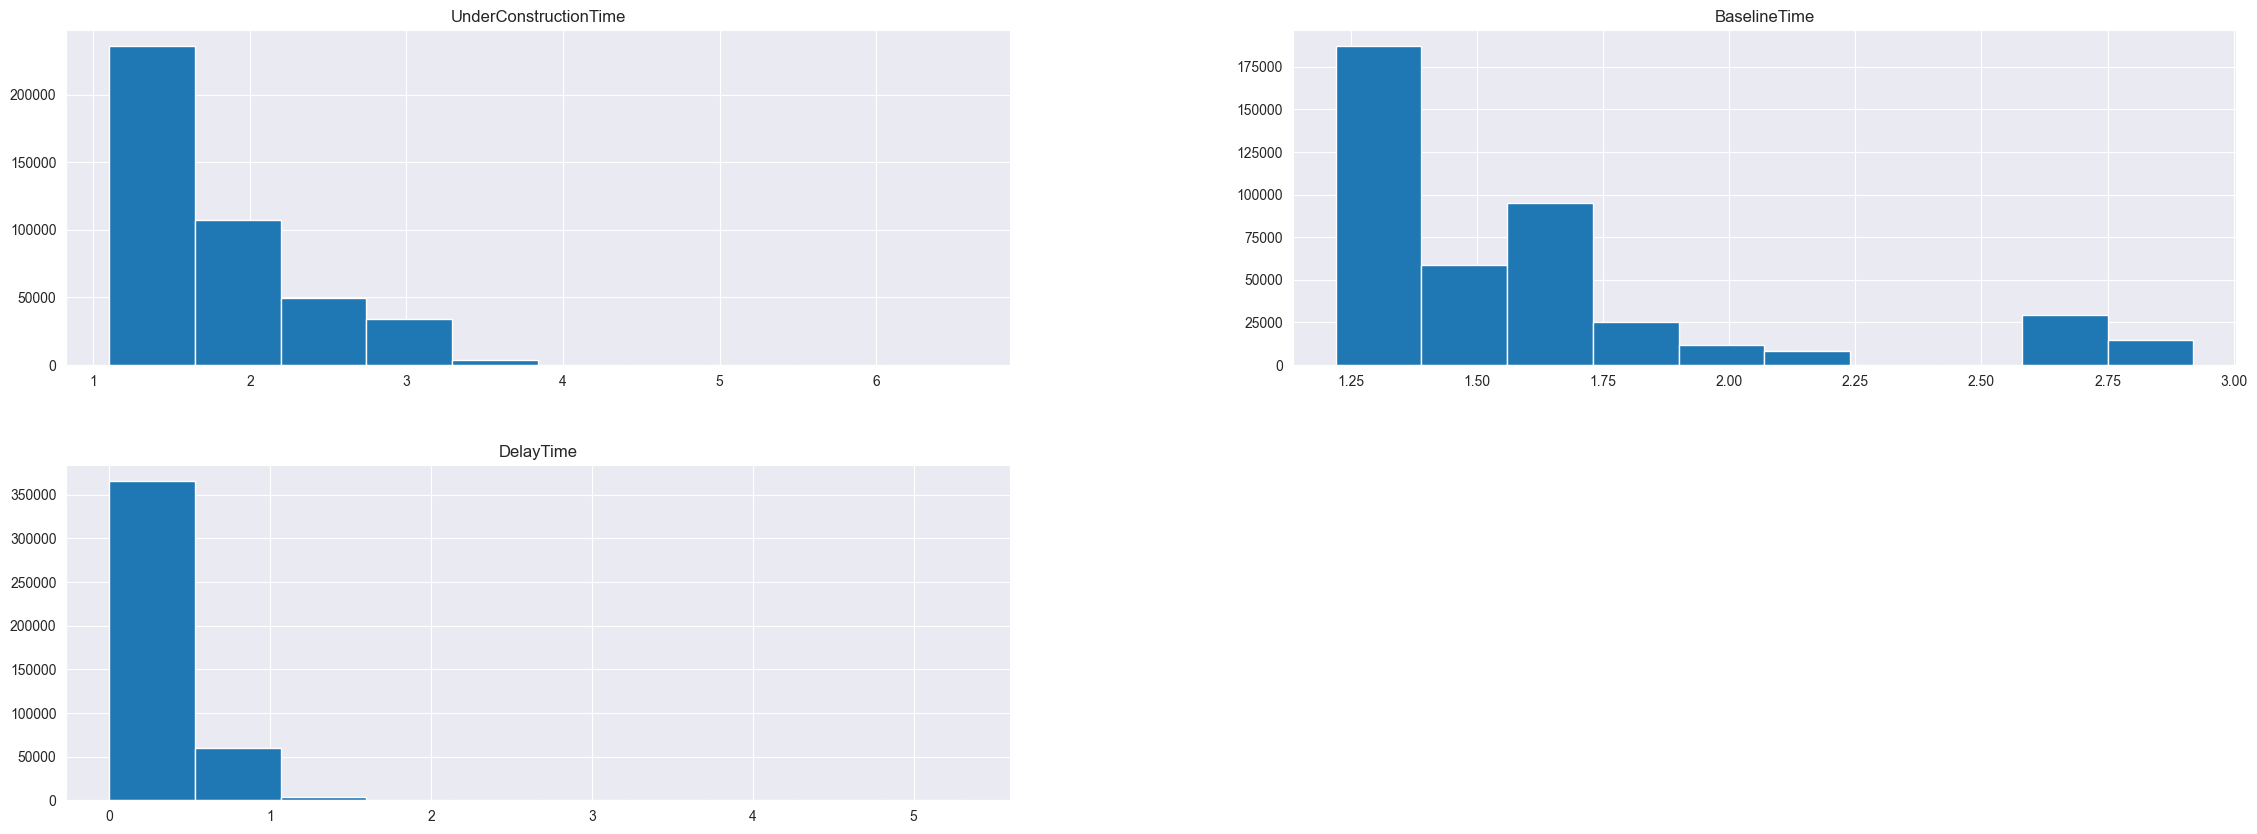

In [25]:
df_processed[['UnderConstructionTime', 'BaselineTime', 'DelayTime']].hist(figsize = (28,10))
# count, division = np.histogram(df_processed['UnderConstructionTime'])
# print(count)
# print(division)
plt.show()

### Correlation Matrix

C:\Users\SALMALIS 2\AppData\Local\Temp\ipykernel_10216\3273951945.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  C_mat = df_processed.corr()


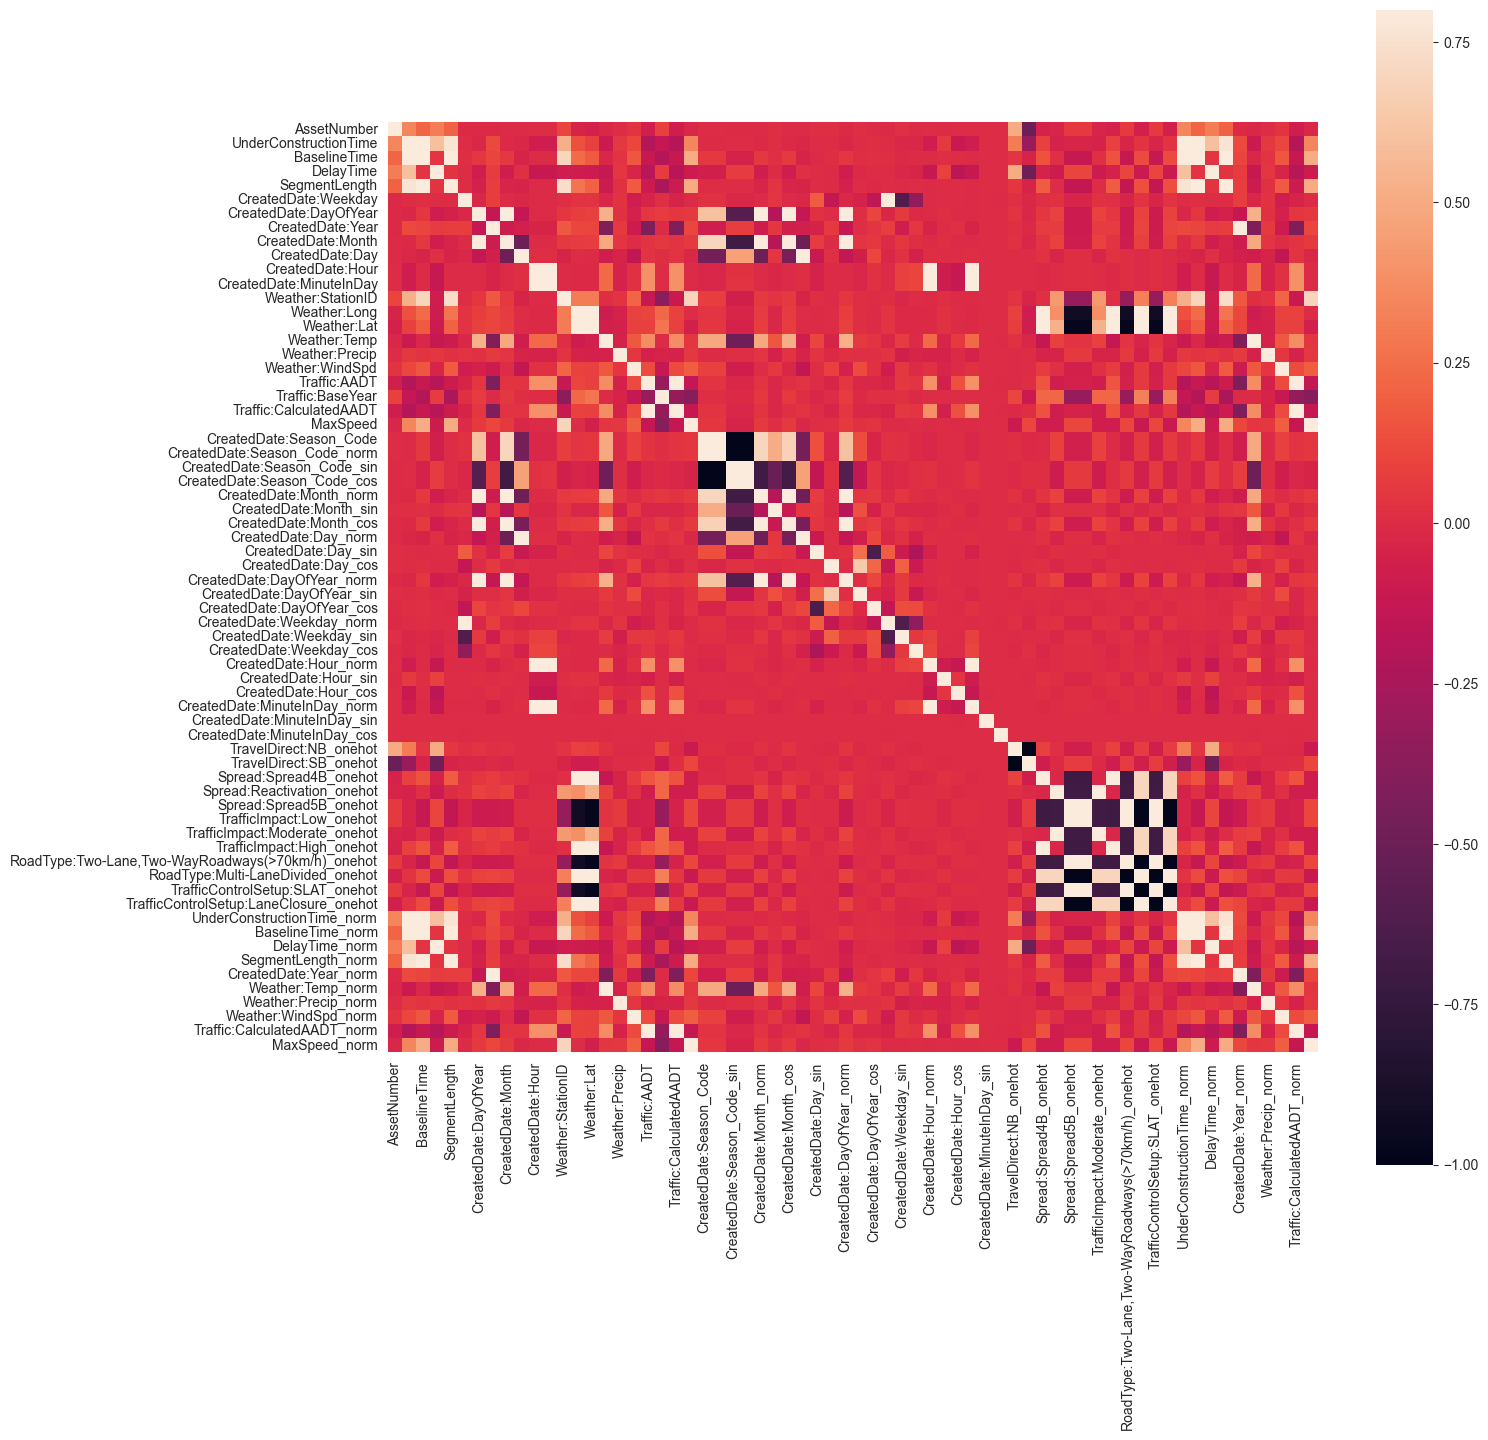

In [26]:
C_mat = df_processed.corr()
fig = plt.figure(figsize = (15,15))

sns.heatmap(C_mat, vmax = .8, square = True)
plt.show()

## Divide into training and test set

In [27]:
df_train, df_test = train_test_split(df_processed, test_size=0.1)
print("train.shape:", df_train.shape)
print("test.shape:", df_test.shape)

train.shape: (387466, 78)
test.shape: (43052, 78)


In [28]:
x_drop_cols = ['UnderConstructionTime_norm','BaselineTime_norm', 'DelayTime_norm', 'AssetNumber', 'AssetIdentifier', 'CreatedDate', 'UnderConstructionTime', 'BaselineTime', 'DelayTime', 'State', 'SegmentLength', 'TravelDirect', 'Spread', 'TrafficImpact', 'RoadType', 'TrafficControlSetup', 'CreatedDate:Date', 'CreatedDate:Weekday','CreatedDate:DayOfYear', 'CreatedDate:Year', 'CreatedDate:Month', 'CreatedDate:Day', 'CreatedDate:Hour', 'CreatedDate:MinuteInDay', 'CreatedDate:Season', 'Weather:StationID', 'Weather:Long', 'Weather:Lat', 'Weather:Temp', 'Weather:Precip', 'Weather:WindSpd', 'Traffic:SiteNo', 'Traffic:IsTemporary', 'Traffic:AADT', 'Traffic:BaseYear', 'Traffic:CalculatedAADT', 'MaxSpeed', 'CreatedDate:Season_Code', 'CreatedDate:Season_Code_norm', 'CreatedDate:Month_norm', 'CreatedDate:Day_norm', 'CreatedDate:DayOfYear_norm', 'CreatedDate:Weekday_norm', 'CreatedDate:Hour_norm','CreatedDate:MinuteInDay_norm']

### Training Set

In [29]:
# df_train = df_processed[~df_processed['AssetNumber'].isin(assets_no_cell)]
# df_train
# df_train.columns

In [30]:
x_train = df_train.copy().drop(columns=x_drop_cols)
print(len(x_train.columns))
print(x_train.columns)
x_train

33
Index(['CreatedDate:Season_Code_sin', 'CreatedDate:Season_Code_cos',
       'CreatedDate:Month_sin', 'CreatedDate:Month_cos', 'CreatedDate:Day_sin',
       'CreatedDate:Day_cos', 'CreatedDate:DayOfYear_sin',
       'CreatedDate:DayOfYear_cos', 'CreatedDate:Weekday_sin',
       'CreatedDate:Weekday_cos', 'CreatedDate:Hour_sin',
       'CreatedDate:Hour_cos', 'CreatedDate:MinuteInDay_sin',
       'CreatedDate:MinuteInDay_cos', 'TravelDirect:NB_onehot',
       'TravelDirect:SB_onehot', 'Spread:Spread4B_onehot',
       'Spread:Reactivation_onehot', 'Spread:Spread5B_onehot',
       'TrafficImpact:Low_onehot', 'TrafficImpact:Moderate_onehot',
       'TrafficImpact:High_onehot',
       'RoadType:Two-Lane,Two-WayRoadways(>70km/h)_onehot',
       'RoadType:Multi-LaneDivided_onehot', 'TrafficControlSetup:SLAT_onehot',
       'TrafficControlSetup:LaneClosure_onehot', 'SegmentLength_norm',
       'CreatedDate:Year_norm', 'Weather:Temp_norm', 'Weather:Precip_norm',
       'Weather:WindSpd_norm',

,CreatedDate:Season_Code_sin,CreatedDate:Season_Code_cos,CreatedDate:Month_sin,CreatedDate:Month_cos,CreatedDate:Day_sin,CreatedDate:Day_cos,CreatedDate:DayOfYear_sin,CreatedDate:DayOfYear_cos,CreatedDate:Weekday_sin,CreatedDate:Weekday_cos,...,RoadType:Multi-LaneDivided_onehot,TrafficControlSetup:SLAT_onehot,TrafficControlSetup:LaneClosure_onehot,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
276478,0.909297,-0.416147,-0.756802,-0.653644,-0.999990,0.004426,0.452026,0.892005,0.000000,1.000000,...,0.0,1.0,0.0,0.353936,0.418173,-0.340073,-0.288588,-0.092609,-0.124494,-0.439603
99846,0.909297,-0.416147,-0.958924,0.283662,0.762558,0.646919,0.996469,0.083959,0.141120,-0.989992,...,0.0,1.0,0.0,-0.747484,0.418173,0.377595,-0.288588,-0.659514,-0.802667,-0.439603
47581,0.909297,-0.416147,-0.756802,-0.653644,0.762558,0.646919,0.236661,-0.971592,0.841471,0.540302,...,0.0,1.0,0.0,2.824687,0.418173,-0.867769,0.696436,-0.092609,-0.404766,1.652840
300447,0.909297,-0.416147,-0.958924,0.283662,0.956376,-0.292139,0.609044,-0.793136,-0.756802,-0.653644,...,0.0,1.0,0.0,-0.792136,0.418173,0.884183,-0.288588,-0.092609,0.243328,-0.439603
54912,0.909297,-0.416147,0.141120,-0.989992,-0.663634,-0.748058,0.035398,0.999373,0.841471,0.540302,...,0.0,1.0,0.0,2.824687,0.418173,-0.825553,-0.288588,0.474295,-0.559900,1.652840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373817,0.909297,-0.416147,-0.958924,0.283662,-0.279415,0.960170,0.329991,0.943984,0.141120,-0.989992,...,0.0,1.0,0.0,0.279515,-2.494814,0.863075,-0.288588,0.096359,-0.405295,-0.439603
227234,0.909297,-0.416147,0.141120,-0.989992,-0.132352,0.991203,0.733190,-0.680023,-0.756802,-0.653644,...,0.0,1.0,0.0,-0.315846,0.418173,-0.318965,-0.288588,0.852231,-0.687722,-0.439603
231902,0.909297,-0.416147,-0.958924,0.283662,0.149877,0.988705,0.696080,0.717964,0.909297,-0.416147,...,0.0,1.0,0.0,-0.315846,-2.494814,0.440918,-0.288588,0.852231,0.995185,-0.439603
347890,0.909297,-0.416147,-0.958924,0.283662,-0.404038,0.914742,0.202150,0.979355,0.841471,0.540302,...,0.0,1.0,0.0,0.279515,0.418173,0.419810,-0.288588,-1.226418,-0.687722,-0.439603


In [31]:
y_train = df_train[['UnderConstructionTime_norm', 'DelayTime_norm']]
y_train

,UnderConstructionTime_norm,DelayTime_norm
276478,1.282863,1.959974
99846,-0.567345,0.105018
47581,2.117271,0.037565
300447,-1.020827,-0.636965
54912,1.845182,-0.468333
...,...,...
373817,-0.295255,-0.636965
227234,1.210306,2.735683
231902,0.067530,0.273650
347890,-0.385952,-0.636965


### Test Set

In [32]:
# df_test = df_processed[df_processed['AssetNumber'].isin(assets_no_cell)]
# df_test

In [33]:
x_test = df_test.copy().drop(columns=x_drop_cols)
print(len(x_test.columns))
# print(x_test.columns)
x_test

33


,CreatedDate:Season_Code_sin,CreatedDate:Season_Code_cos,CreatedDate:Month_sin,CreatedDate:Month_cos,CreatedDate:Day_sin,CreatedDate:Day_cos,CreatedDate:DayOfYear_sin,CreatedDate:DayOfYear_cos,CreatedDate:Weekday_sin,CreatedDate:Weekday_cos,...,RoadType:Multi-LaneDivided_onehot,TrafficControlSetup:SLAT_onehot,TrafficControlSetup:LaneClosure_onehot,SegmentLength_norm,CreatedDate:Year_norm,Weather:Temp_norm,Weather:Precip_norm,Weather:WindSpd_norm,Traffic:CalculatedAADT_norm,MaxSpeed_norm
115073,0.909297,-0.416147,-0.756802,-0.653644,0.270906,-0.962606,-0.981952,0.189129,0.141120,-0.989992,...,0.0,1.0,0.0,-0.747484,0.418173,-0.424504,-0.288588,-0.659514,-0.170472,-0.439603
153485,0.909297,-0.416147,-0.756802,-0.653644,-0.663634,-0.748058,-0.371404,0.928471,0.141120,-0.989992,...,0.0,1.0,0.0,-0.807020,-2.494814,1.390772,-0.288588,-0.281577,3.605021,-0.439603
410392,0.909297,-0.416147,-0.958924,0.283662,-0.404038,0.914742,0.202150,0.979355,0.841471,0.540302,...,0.0,1.0,0.0,-0.702832,0.418173,1.665174,-0.288588,3.119849,-0.124494,-0.439603
286352,0.141120,-0.989992,-0.279415,0.960170,0.412118,-0.911130,0.219425,-0.975629,0.909297,-0.416147,...,0.0,1.0,0.0,0.353936,-2.494814,0.820860,-0.288588,-0.092609,0.374647,-0.439603
319846,0.141120,-0.989992,-0.279415,0.960170,0.841471,0.540302,0.933321,0.359044,0.909297,-0.416147,...,0.0,1.0,0.0,-0.792136,0.418173,2.636136,-0.288588,0.663263,0.387009,-0.439603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
227885,0.909297,-0.416147,-0.958924,0.283662,-0.961397,-0.275163,-0.942514,0.334165,0.841471,0.540302,...,0.0,1.0,0.0,-0.315846,0.418173,-0.297857,-0.288588,-1.037450,-0.400361,-0.439603
101359,0.909297,-0.416147,-0.958924,0.283662,-0.961397,-0.275163,-0.942514,0.334165,0.841471,0.540302,...,0.0,1.0,0.0,-0.747484,0.418173,-0.741122,-0.288588,-1.226418,-0.802667,-0.439603
40848,0.141120,-0.989992,-0.279415,0.960170,0.841471,0.540302,0.933321,0.359044,0.909297,-0.416147,...,0.0,1.0,0.0,2.824687,0.418173,0.968615,-0.288588,-0.848482,0.091664,1.652840
2672,0.141120,-0.989992,-0.279415,0.960170,0.141120,-0.989992,-0.061920,-0.998081,-0.756802,-0.653644,...,1.0,0.0,1.0,0.026487,0.418173,0.398703,-0.288588,0.096359,-0.348365,-0.439603


In [34]:
y_test = df_test[['UnderConstructionTime_norm', 'DelayTime_norm']]
y_test

,UnderConstructionTime_norm,DelayTime_norm
115073,-0.930131,-0.636965
153485,-0.966409,-0.636965
410392,-0.803156,-0.502059
286352,0.430317,0.442282
319846,-0.966409,-0.636965
...,...,...
227885,-0.567345,-0.636965
101359,-0.966409,-0.636965
40848,2.461918,0.037565
2672,0.067530,-0.063615


# Model

In [35]:
model = Sequential()

model.add(Dense(units=128, input_dim=x_train.shape[1], activation='relu'))

model.add(Dense(units=512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=128, activation='relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(units=2, activation='tanh'))
# model.add(Dense(units=2, activation='sigmoid'))

model.compile(optimizer='adam', loss='mse')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               4352      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               66048     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 2

## Fit

In [36]:
# Define the Keras TensorBoard callback.
logdir = "../logs/" + datetime.now().strftime("%d-%H_%M")
tensorboard_callback = TensorBoard(log_dir=logdir)
# tensorboard_callback = TensorBoard(log_dir=logdir,
#                                    histogram_freq=1,
#                                    write_graph=True,
#                                    write_images=True,
#                                    update_freq='epoch',
#                                    profile_batch=2,
#                                    embeddings_freq=1)

In [37]:
earlystopping_callback = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)

In [40]:
# model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_test, y_test), callbacks=[tensorboard_callback, earlystopping_callback], verbose=1)
model.fit(x_train, y_train, epochs=700, batch_size=1024, validation_data=(x_test, y_test), callbacks=[tensorboard_callback, earlystopping_callback], verbose=1)


Epoch 1/700
379/379 [==============================] - 3s 4ms/step - loss: 0.3837 - val_loss: 0.3017
Epoch 2/700
379/379 [==============================] - 1s 3ms/step - loss: 0.3095 - val_loss: 0.2834
Epoch 3/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2928 - val_loss: 0.2742
Epoch 4/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2837 - val_loss: 0.2648
Epoch 5/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2771 - val_loss: 0.2623
Epoch 6/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2733 - val_loss: 0.2584
Epoch 7/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2698 - val_loss: 0.2553
Epoch 8/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2675 - val_loss: 0.2537
Epoch 9/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2659 - val_loss: 0.2526
Epoch 10/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2644 - val_lo

Epoch 1/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2360 - val_loss: 0.2286
Epoch 2/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2360 - val_loss: 0.2287
Epoch 3/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2423 - val_loss: 0.2448
Epoch 4/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2513 - val_loss: 0.2426
Epoch 5/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2495 - val_loss: 0.2385
Epoch 6/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2381 - val_loss: 0.2288
Epoch 7/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2366 - val_loss: 0.2287
Epoch 8/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2362 - val_loss: 0.2289
Epoch 9/700
379/379 [==============================] - 1s 3ms/step - loss: 0.2474 - val_loss: 0.2420
Epoch 10/700
379/379 [==============================] - 1s 2ms/step - loss: 0.2417 - val_lo

## Evaluate Model

In [41]:
# %tensorboard --logdir logs

In [42]:
# y_pred = model.predict(x_train[-set_aside:])
# r2_score(y_train[-set_aside:], y_pred)

In [43]:
y_pred = model.predict(x_test)
r2_score(y_test, y_pred)

0.76822949198258

## Save

In [55]:
model.save(os.path.join(output_root_path, "trained_model", datetime.now().strftime("model_%d-%H_%M")))
model.save_weights(os.path.join(output_root_path, "trained_model/" + datetime.now().strftime("model_%d-%H_%M"), datetime.now().strftime("model_%d-%H_%M")))

INFO:tensorflow:Assets written to: ../trained_model\model_21-18_05\assets
